In [99]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

In [100]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 256])
for i in range(0, 10):
    inputImageDir = './input/' + str(i) + '.png'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
#     threshold = 12  
#     inputImage = inputImage.point(lambda p: p > threshold and 255)
#     inputImage.show()
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [101]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, num_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.inputlayer = nn.Linear(input_size, num_hidden)
        self.hiddenlayer = nn.Linear(num_hidden, num_hidden)
        self.outputlayer = nn.Linear(num_hidden, num_classes)
        self.activate = nn.Sigmoid()

    def forward(self, x):
        res = self.inputlayer(x)
        res = self.activate(res)
        res = self.hiddenlayer(x)
        res = self.activate(res)
        res = self.outputlayer(x)
        res = self.activate(res)
        return res

In [102]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [103]:
# Parameters of training
input_size = 256
num_classes = 256
num_hidden = 256
learning_rate = 0.001
batch_size = 10
num_epochs = 600

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, num_hidden=num_hidden, num_classes=num_classes).to(device)

if not os.path.exists('./models'):
    os.mkdir('./models')
torch.save(model, './models/net_untrained.pkl')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(train_dataset.dataset)


In [104]:
# Step 3
def train(dataloader, model, num_epochs):
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = [] 
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
#             print('real: %s' % real)
#             print('label: %s' % label)
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(output.data)
#             print(error)
#             print(error.shape)
            ERROR_Train.extend(error)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
            
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2709 MAE: 0.5044 Mean Error: 0.4149 STD: 0.3143
[10/600] Loss: 0.0446 MAE: 0.1605 Mean Error: 0.0982 STD: 0.1871
[20/600] Loss: 0.0309 MAE: 0.0919 Mean Error: 0.0351 STD: 0.1722
[30/600] Loss: 0.0283 MAE: 0.0778 Mean Error: 0.0207 STD: 0.1670
[40/600] Loss: 0.0266 MAE: 0.0735 Mean Error: 0.0167 STD: 0.1622
[50/600] Loss: 0.0251 MAE: 0.0711 Mean Error: 0.0147 STD: 0.1578
[60/600] Loss: 0.0237 MAE: 0.0690 Mean Error: 0.0144 STD: 0.1533
[70/600] Loss: 0.0224 MAE: 0.0675 Mean Error: 0.0136 STD: 0.1491
[80/600] Loss: 0.0212 MAE: 0.0660 Mean Error: 0.0130 STD: 0.1451
[90/600] Loss: 0.0201 MAE: 0.0645 Mean Error: 0.0125 STD: 0.1411
[100/600] Loss: 0.0190 MAE: 0.0629 Mean Error: 0.0122 STD: 0.1372
[110/600] Loss: 0.0180 MAE: 0.0613 Mean Error: 0.0119 STD: 0.1335
[120/600] Loss: 0.0170 MAE: 0.0597 Mean Error: 0.0116 STD: 0.1298
[130/600] Loss: 0.0161 MAE: 0.0581 Mean Error: 0.0113 STD: 0.1263
[140/600] Loss: 0.0152 MAE: 0.0566 Mean Error: 0.0110 STD: 0.1229
[150/600] Loss: 0.014

In [105]:
# Step 4
# Step 4a
# Export the image after training
# Before executing this block, create a folder called "output"
if not os.path.exists('./output'):
    os.mkdir('./output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models/net_trained.pkl')
output_dataset = np.zeros([10, 256])
for i in range(10):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
#     img = img.convert("1")
    threshold = 50
    img = img.point(lambda p: p > threshold and 255)
    output_path = './output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

(10, 256)


In [106]:
# Step 4b
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [107]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [108]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

[0.92       0.91891892 0.95       0.92771084 0.94285714 0.9379845
 0.92207792 0.92899408 0.93877551 0.94117647]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [109]:
# TODO: Step 4c: Graph Fh as a function of Ffa for each exemplar in the input dataset

In [110]:
# Step 5
def gaussian_noise(img, mean, sigma):
    # Generate gauss noise
    noise = np.random.normal(mean, sigma, img.shape)
    # Add the noise to image
    gaussian_out = img + noise
    # Make the value between 0 and 1
    gaussian_out = np.clip(gaussian_out, 0, 1)
    return gaussian_out

gaussian_dataset = np.zeros([9, 10, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
if not os.path.exists('./input_noise/'):
    os.mkdir('./input_noise/')
for j in range(9):
    if not os.path.exists('./input_noise/' + str(std[j])):
        os.mkdir('./input_noise/' + str(std[j]))
    for i in range(10):
        inputImage = dataSet[i]
        gaussian_data = gaussian_noise(inputImage, 0, std[j])
        img = gaussian_data.reshape(16, 16)*255
        img = Image.fromarray(np.uint8(img))
        img.convert("1")
        inputImageDir = './input_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(inputImageDir)
        gaussian_dataset[j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)


Fh_noise_array = np.zeros([9, 10])
Ffa_noise_array = np.zeros([9, 10])

# Train 9 datasets with noise
if not os.path.exists('./output_noise/'):
    os.mkdir('./output_noise/')
for j in range(9):
    train_noise_dataset = DigitDataset(dataset = gaussian_dataset[j], label_list = dataSet)
    train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
    print('Training dataset with noise standard deviation ' + str(std[j]))
#     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
    model_noise = Perceptron(input_size=input_size, num_hidden=num_hidden, num_classes=num_classes).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)
    output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
    torch.save(model_noise, './models/net_trained_' + str(std[j]) + '.pkl')
    model_noise = torch.load('./models/net_trained_' + str(std[j]) + '.pkl')
#     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
    print('------------------------------------')
    output_noise = model_noise(torch.from_numpy(dataSet).float())
    output_noise_np = output_noise.detach().numpy()     # Get the output
#     print(output_noise_np)
    output_noise_dataset = np.zeros([10, 256])
#     Make the output only has 0 or 1
    
    if not os.path.exists('./output_noise/' + str(std[j])):
        os.mkdir('./output_noise/' + str(std[j]))
    for i in range(10):
        output_noise_img = output_noise_np[i].reshape(16, 16)*255
        img = Image.fromarray(np.uint8(output_noise_img))
#         img = img.convert("1")
        threshold = 50
        img = img.point(lambda p: p > threshold and 255)
        output_path = './output_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(output_path)
        data = img.getdata()
        array = np.array(data)/255
        output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    Fh = calculateFh(dataSet, output_noise_dataset)
    Ffa = calculateFfa(dataSet, output_noise_dataset)
    Fh_noise_array[j] = Fh
    Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

Training dataset with noise standard deviation 0.001
[0/600] Loss: 0.2626 MAE: 0.4977 Mean Error: 0.4060 STD: 0.3127
[10/600] Loss: 0.0438 MAE: 0.1579 Mean Error: 0.0963 STD: 0.1858
[20/600] Loss: 0.0307 MAE: 0.0918 Mean Error: 0.0329 STD: 0.1722
[30/600] Loss: 0.0282 MAE: 0.0781 Mean Error: 0.0204 STD: 0.1666
[40/600] Loss: 0.0265 MAE: 0.0734 Mean Error: 0.0164 STD: 0.1619
[50/600] Loss: 0.0250 MAE: 0.0704 Mean Error: 0.0150 STD: 0.1574
[60/600] Loss: 0.0236 MAE: 0.0685 Mean Error: 0.0144 STD: 0.1530
[70/600] Loss: 0.0223 MAE: 0.0669 Mean Error: 0.0134 STD: 0.1487
[80/600] Loss: 0.0211 MAE: 0.0655 Mean Error: 0.0128 STD: 0.1446
[90/600] Loss: 0.0199 MAE: 0.0641 Mean Error: 0.0123 STD: 0.1406
[100/600] Loss: 0.0189 MAE: 0.0625 Mean Error: 0.0120 STD: 0.1368
[110/600] Loss: 0.0178 MAE: 0.0609 Mean Error: 0.0118 STD: 0.1331
[120/600] Loss: 0.0169 MAE: 0.0593 Mean Error: 0.0115 STD: 0.1295
[130/600] Loss: 0.0160 MAE: 0.0578 Mean Error: 0.0111 STD: 0.1261
[140/600] Loss: 0.0152 MAE: 0.0563

[60/600] Loss: 0.0237 MAE: 0.0693 Mean Error: 0.0134 STD: 0.1533
[70/600] Loss: 0.0223 MAE: 0.0677 Mean Error: 0.0129 STD: 0.1490
[80/600] Loss: 0.0211 MAE: 0.0660 Mean Error: 0.0126 STD: 0.1448
[90/600] Loss: 0.0200 MAE: 0.0644 Mean Error: 0.0122 STD: 0.1408
[100/600] Loss: 0.0189 MAE: 0.0627 Mean Error: 0.0119 STD: 0.1369
[110/600] Loss: 0.0178 MAE: 0.0611 Mean Error: 0.0116 STD: 0.1331
[120/600] Loss: 0.0169 MAE: 0.0595 Mean Error: 0.0114 STD: 0.1294
[130/600] Loss: 0.0160 MAE: 0.0580 Mean Error: 0.0111 STD: 0.1259
[140/600] Loss: 0.0151 MAE: 0.0564 Mean Error: 0.0108 STD: 0.1225
[150/600] Loss: 0.0143 MAE: 0.0549 Mean Error: 0.0106 STD: 0.1192
[160/600] Loss: 0.0136 MAE: 0.0535 Mean Error: 0.0104 STD: 0.1160
[170/600] Loss: 0.0129 MAE: 0.0521 Mean Error: 0.0102 STD: 0.1130
[180/600] Loss: 0.0122 MAE: 0.0508 Mean Error: 0.0100 STD: 0.1101
[190/600] Loss: 0.0116 MAE: 0.0495 Mean Error: 0.0098 STD: 0.1073
[200/600] Loss: 0.0110 MAE: 0.0482 Mean Error: 0.0096 STD: 0.1046
[210/600] Loss

[80/600] Loss: 0.0213 MAE: 0.0656 Mean Error: 0.0129 STD: 0.1455
[90/600] Loss: 0.0202 MAE: 0.0641 Mean Error: 0.0126 STD: 0.1416
[100/600] Loss: 0.0191 MAE: 0.0627 Mean Error: 0.0122 STD: 0.1378
[110/600] Loss: 0.0181 MAE: 0.0613 Mean Error: 0.0118 STD: 0.1342
[120/600] Loss: 0.0172 MAE: 0.0598 Mean Error: 0.0115 STD: 0.1307
[130/600] Loss: 0.0163 MAE: 0.0583 Mean Error: 0.0112 STD: 0.1273
[140/600] Loss: 0.0155 MAE: 0.0568 Mean Error: 0.0109 STD: 0.1240
[150/600] Loss: 0.0147 MAE: 0.0554 Mean Error: 0.0107 STD: 0.1208
[160/600] Loss: 0.0140 MAE: 0.0540 Mean Error: 0.0104 STD: 0.1177
[170/600] Loss: 0.0133 MAE: 0.0527 Mean Error: 0.0102 STD: 0.1147
[180/600] Loss: 0.0126 MAE: 0.0514 Mean Error: 0.0100 STD: 0.1118
[190/600] Loss: 0.0120 MAE: 0.0502 Mean Error: 0.0098 STD: 0.1090
[200/600] Loss: 0.0114 MAE: 0.0489 Mean Error: 0.0096 STD: 0.1063
[210/600] Loss: 0.0108 MAE: 0.0478 Mean Error: 0.0094 STD: 0.1037
[220/600] Loss: 0.0103 MAE: 0.0466 Mean Error: 0.0092 STD: 0.1012
[230/600] Lo

[100/600] Loss: 0.0189 MAE: 0.0630 Mean Error: 0.0124 STD: 0.1369
[110/600] Loss: 0.0179 MAE: 0.0614 Mean Error: 0.0121 STD: 0.1332
[120/600] Loss: 0.0169 MAE: 0.0599 Mean Error: 0.0118 STD: 0.1295
[130/600] Loss: 0.0160 MAE: 0.0583 Mean Error: 0.0115 STD: 0.1260
[140/600] Loss: 0.0151 MAE: 0.0568 Mean Error: 0.0113 STD: 0.1226
[150/600] Loss: 0.0143 MAE: 0.0553 Mean Error: 0.0110 STD: 0.1193
[160/600] Loss: 0.0136 MAE: 0.0539 Mean Error: 0.0108 STD: 0.1161
[170/600] Loss: 0.0129 MAE: 0.0525 Mean Error: 0.0105 STD: 0.1130
[180/600] Loss: 0.0122 MAE: 0.0512 Mean Error: 0.0103 STD: 0.1100
[190/600] Loss: 0.0116 MAE: 0.0499 Mean Error: 0.0101 STD: 0.1072
[200/600] Loss: 0.0110 MAE: 0.0486 Mean Error: 0.0099 STD: 0.1044
[210/600] Loss: 0.0105 MAE: 0.0474 Mean Error: 0.0097 STD: 0.1018
[220/600] Loss: 0.0099 MAE: 0.0462 Mean Error: 0.0095 STD: 0.0993
[230/600] Loss: 0.0095 MAE: 0.0451 Mean Error: 0.0093 STD: 0.0968
[240/600] Loss: 0.0090 MAE: 0.0440 Mean Error: 0.0091 STD: 0.0945
[250/600] 

[140/600] Loss: 0.0137 MAE: 0.0549 Mean Error: 0.0115 STD: 0.1163
[150/600] Loss: 0.0128 MAE: 0.0532 Mean Error: 0.0112 STD: 0.1127
[160/600] Loss: 0.0120 MAE: 0.0517 Mean Error: 0.0109 STD: 0.1092
[170/600] Loss: 0.0113 MAE: 0.0502 Mean Error: 0.0106 STD: 0.1059
[180/600] Loss: 0.0106 MAE: 0.0487 Mean Error: 0.0103 STD: 0.1027
[190/600] Loss: 0.0100 MAE: 0.0473 Mean Error: 0.0101 STD: 0.0996
[200/600] Loss: 0.0094 MAE: 0.0460 Mean Error: 0.0098 STD: 0.0967
[210/600] Loss: 0.0089 MAE: 0.0447 Mean Error: 0.0096 STD: 0.0939
[220/600] Loss: 0.0084 MAE: 0.0435 Mean Error: 0.0094 STD: 0.0912
[230/600] Loss: 0.0079 MAE: 0.0424 Mean Error: 0.0092 STD: 0.0887
[240/600] Loss: 0.0075 MAE: 0.0413 Mean Error: 0.0090 STD: 0.0862
[250/600] Loss: 0.0071 MAE: 0.0402 Mean Error: 0.0088 STD: 0.0839
[260/600] Loss: 0.0067 MAE: 0.0392 Mean Error: 0.0086 STD: 0.0817
[270/600] Loss: 0.0064 MAE: 0.0382 Mean Error: 0.0084 STD: 0.0796
[280/600] Loss: 0.0061 MAE: 0.0373 Mean Error: 0.0082 STD: 0.0776
[290/600] 

In [13]:
# TODO: Step 6: Display Data from your Tests in Step 5

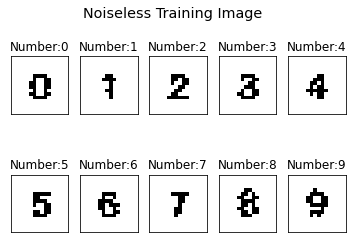

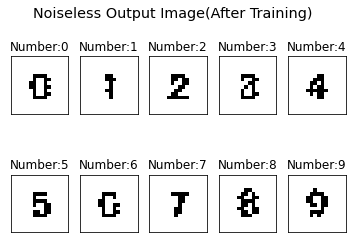

In [111]:
N=2
M=5
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Noiseless Training Image", fontsize="x-large")
for i in range(10):#有10张图片
    path='./input/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

N=2
M=5
fig = plt.figure()
st = fig.suptitle("Noiseless Output Image(After Training)", fontsize="x-large")
for i in range(10):#有10张图片
    path='./output/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

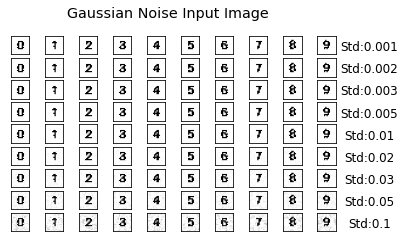

In [112]:
std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=500
M=500
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Input Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./input_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = ("Std:"+str(j))
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

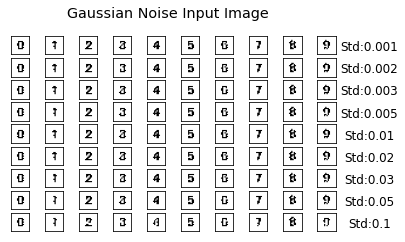

In [113]:
# Display the Onput Image with Noise 
import matplotlib.pyplot as plt
import numpy as np
std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=100
M=100
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Input Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./output_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = "Std:"+str(j)
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

No handles with labels found to put in legend.


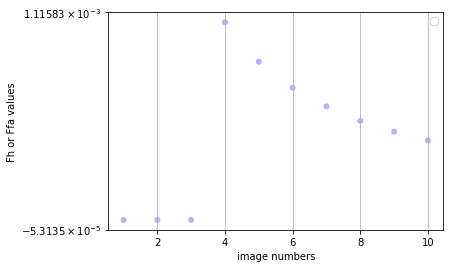

In [64]:
import numpy as np
import matplotlib.pyplot as plt

std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", alpha=0.3, edgecolors='none')
ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
plt.yscale("symlog")
plt.show()


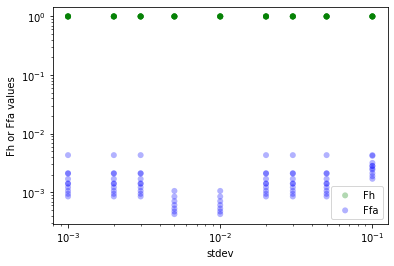

In [63]:
# noise
fig, ax = plt.subplots()
ax.scatter(std_plot, Fh_noise_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(std_plot, Ffa_noise_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
plt.xlabel("stdev")
plt.ylabel("Fh or Ffa values")
plt.xscale("log")
plt.yscale("log")
ax.legend()
plt.show()

In [81]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 256])
for i in range(0, 10):
#     print(os. getcwd())
    inputImageDir = './input_noise/' + str(i) + '.png'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
#     threshold = 12  
#     inputImage = inputImage.point(lambda p: p > threshold and 255)
#     inputImage.show()
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

C:\Users\zhhua\Desktop\UF\2022Spring\CAP6615\Assignments\Assignment1


FileNotFoundError: [Errno 2] No such file or directory: './input_noise/0.png'

In [87]:
gaussian_dataset = np.zeros([9, 10, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
# std = [0.001]
if not os.path.exists('./input_noise/'):
    os.mkdir('./input_noise/')
# for j in range(9):
for j in range(9):
    if not os.path.exists('./input_noise/' + str(std[j])):
        os.mkdir('./input_noise/' + str(std[j]))
    for i in range(10):
        inputImage = dataSet[i]
        gaussian_data = gaussian_noise(inputImage, 0, std[j])
        img = gaussian_data.reshape(16, 16)*255
        img = Image.fromarray(np.uint8(img))
        img.convert("1")
#         threshold = 12
#         img = img.point(lambda p: p > threshold and 255)
#         img.show()
        inputImageDir = './input_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(inputImageDir)
        gaussian_dataset[j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)
